In [1]:
using Revise
using TransportBasedInference
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using Distributions
using Statistics
using SparseArrays
using LinearMaps
using RecursiveArrayTools

Precompiling HierarchicalDA
  ✓ HierarchicalDA
  1 dependency successfully precompiled in 7 seconds. 500 already precompiled.


In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [169]:
polydeg = 3
Ncells = 100
Nvar = 3

Nxvar = (polydeg+1)*Ncells
Nx = Nvar*Nxvar
Δ = 20

Nyvar = ceil(Int64, Nxvar/Δ)
Ny = Nvar*Nyvar

# Define Trixi system for inviscid Burgers equation
sys_euler = setup_euler(polydeg, Ncells);

xgrid = vec(sys_euler.mesh.md.xq);

Define polynomial annihilator operator

In [197]:
order_PA = 3

Nsvar = Nxvar - 2*ceil(Int64, order_PA/2)
Ns = Nvar*Nsvar

PA = PolyAnnil(xgrid, order_PA; Nvar = Nvar, istruncated = true)

@assert size(PA.P) == (Ns, Nx)

S = LinearMaps.FunctionMap{Float64,true}((s,x)->mul!(s, PA.P, x), (x,s)->mul!(x, PA.P', s),
Ns, Nx; issymmetric=false, isposdef=false)

xs = xgrid[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)];

In [198]:
idxρ = 1:length(xgrid)
idxv = length(xgrid) .+ collect(1:length(xgrid))
idxp = 2*length(xgrid) .+ collect(1:length(xgrid));

idxρy = 1:ceil(Int64, Nx/(Δ*Nvar))
idxvy = ceil(Int64, Nx/(Δ*Nvar)) .+ collect(1:ceil(Int64, Nx/(Δ*Nvar)))
idxpy = 2*ceil(Int64, Nx/(Δ*Nvar)) .+ collect(1:ceil(Int64, Nx/(Δ*Nvar)))

idxρs = idxρ[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]
idxvs = idxv[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]
idxps = idxp[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)];

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [287]:
Δtdyn = 0.02
Δtobs = 0.02

0.02

Define the time span of interest

In [288]:
t0 = 0.0
Tf = 200
Tspin = 1000
tf = t0 + Tf*Δtobs

4.0

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [289]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 1200
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [292]:
σx_true = 0.01#Δtobs*1.0
σx = 0.01#copy(σx_true)
@show σx


σy = 0.1

ϵx_true = AdditiveInflation(Nx, zeros(Nx), σx_true)
ϵx = AdditiveInflation(Nx, zeros(Nx), σx)

ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

σx = 0.01


AdditiveInflation(60, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010000000000000002 0.0 … 0.0 0.0; 0.0 0.010000000000000002 … 0.0 0.0; … ; 0.0 0.0 … 0.010000000000000002 0.0; 0.0 0.0 … 0.0 0.010000000000000002], [0.1 0.0 … 0.0 0.0; 0.0 0.1 … 0.0 0.0; … ; 0.0 0.0 … 0.1 0.0; 0.0 0.0 … 0.0 0.1])

Setup system for compressible Euler equation

In [293]:
h(x, t) = x[unroll(1:Δ:length(xgrid), length(xgrid), Nvar)]
H = LinearMap(sparse(Matrix(1.0*I, Nx, Nx)[unroll(1:Δ:length(xgrid), length(xgrid), Nvar),:]))
F = StateSpace(x->x, h)

StateSpace(var"#65#66"(), TransportBasedInference.var"#27#28"(), h)

Define ObsConstraintSystem

In [294]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx_true, ϵy, π0, 0, 0, 0, F);

In [295]:
# Define function class for the initial condition
αk = 1.0
f0 = SmoothPeriodic(xgrid, αk; L = 10.0, Nvar = Nvar)

SmoothPeriodic(400, 3, 10.0, 1.0, ComplexF64[0.030495116908191258 + 0.5445322226895996im, -0.43132140822239134 - 0.0502920643824652im, -0.20170638156246434 + 0.09728096319595463im, 0.29093961890981246 + 0.02672191546061762im, -0.0866390781859402 - 0.0255610575553602im, 0.07791903643413087 + 0.01255164826391198im, -0.000869639659608297 - 0.014428780868379093im, -0.027288253733951242 - 0.00019169196441383343im, -0.0033222270532088875 + 0.007694843640802244im, -0.008176139136021398 - 0.008605513160777772im  …  5.121496270600014e-86 - 2.1600105010213766e-86im, 4.704705396745198e-86 - 1.1348321263055552e-85im, -7.448960367590558e-87 - 1.5082447826626381e-86im, -2.7353768390593417e-86 + 9.804898427526886e-87im, 4.915936393034705e-87 + 1.0191532477078504e-86im, 1.5726542638032288e-86 - 5.3780345270796295e-87im, 5.29493478930107e-87 - 4.766464435196449e-87im, -4.783351098000505e-87 - 1.6480285404393889e-87im, 5.686514950701028e-89 - 7.138111258728264e-88im, -1.4148544505446147e-87 - 5.66835776

In [296]:
xshuosher = zeros(Nx)
x0 = zeros(Nx)

for (i, xi) in enumerate(xgrid)
    x̃i = cons2prim(initial_condition_shu_osher(xi, 0.0, sys_euler.equations), sys_euler.equations)
    for k=1:Nvar
        xshuosher[((polydeg+1)*Ncells)*(k-1) + i] = x̃i[k]
    end
end

x0 = copy(xshuosher) + 0.01*f0(xgrid);
# x0 = f0(xgrid);

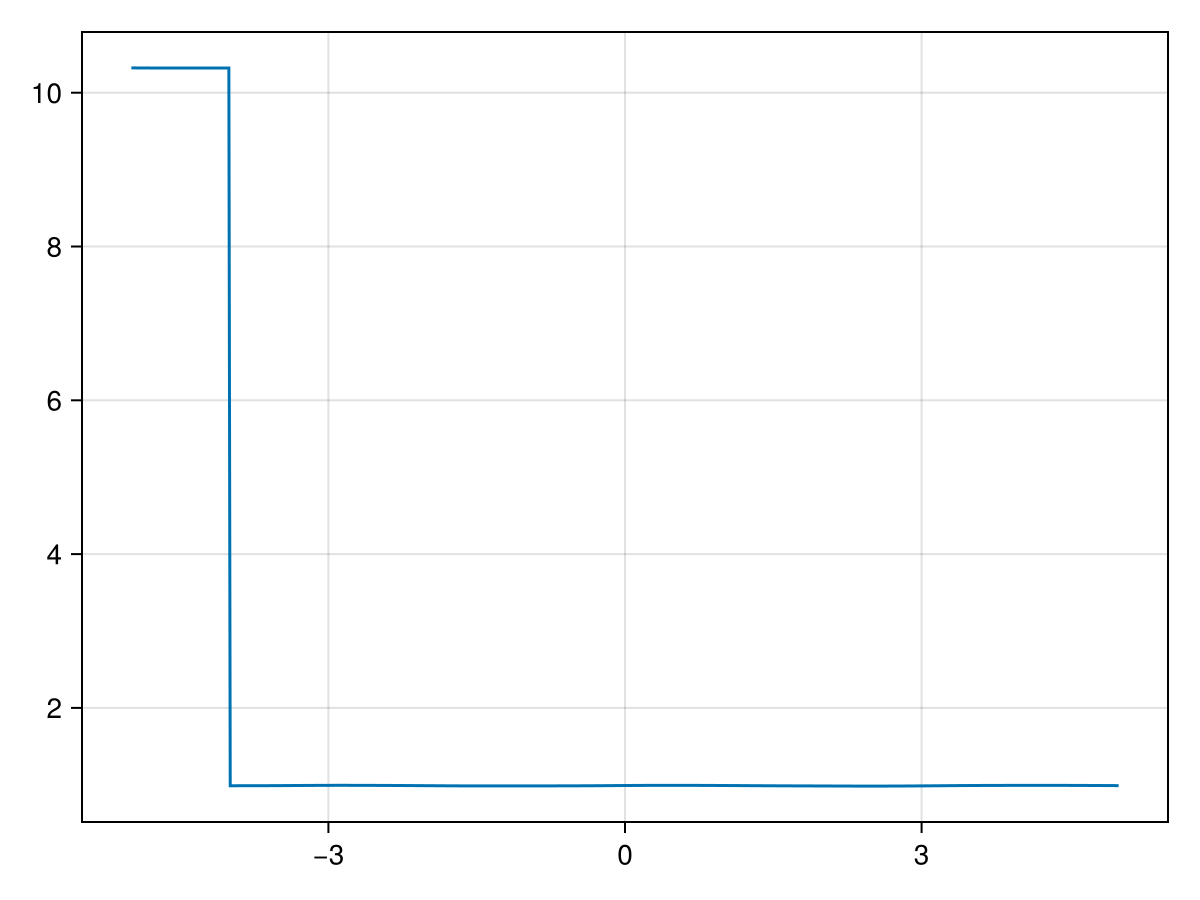

In [297]:
lines(xgrid, x0[idxp])

In [298]:
@time data = generate_data_trixi(model, x0, Tf, sys_euler)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.145165 seconds (71.74 k allocations: 52.013 MiB, 0.38% compilation time)


SyntheticData([0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2  …  3.8200000000000003, 3.84, 3.86, 3.88, 3.9, 3.92, 3.94, 3.96, 3.98, 4.0], 0.02, [3.8555291963478036, 3.8555212631676667, 3.8555292251400313, 3.8555499596547027, 3.855566363768438, 3.8556074436323873, 3.855681700410474, 3.8557547644654884, 3.855799489935995, 3.855894332048794  …  0.9908820234698646, 0.9907181588061345, 0.9906289371873788, 0.9904583423954303, 0.9902304874444268, 0.9900527198407747, 0.9899571766668163, 0.9897769039133979, 0.9895409960392989, 0.9893607924003757], [3.8646575805904564 3.8749211968169486 … 3.86174640226149 3.8672619550139635; 3.8782103414813047 3.873809189678476 … 3.857712161527203 3.855946869081541; … ; 0.9953325936414162 1.0007215014351287 … 9.230160989527477 9.254486650892776; 0.9822804131425807 0.983819953260988 … 8.616804080266991 8.5618168463356], [4.016088960733276 3.8514406032287996 … 3.9667711561019328 3.769723768331391; 3.850453993681336 3.8320440647510154 … 3.822636710688417

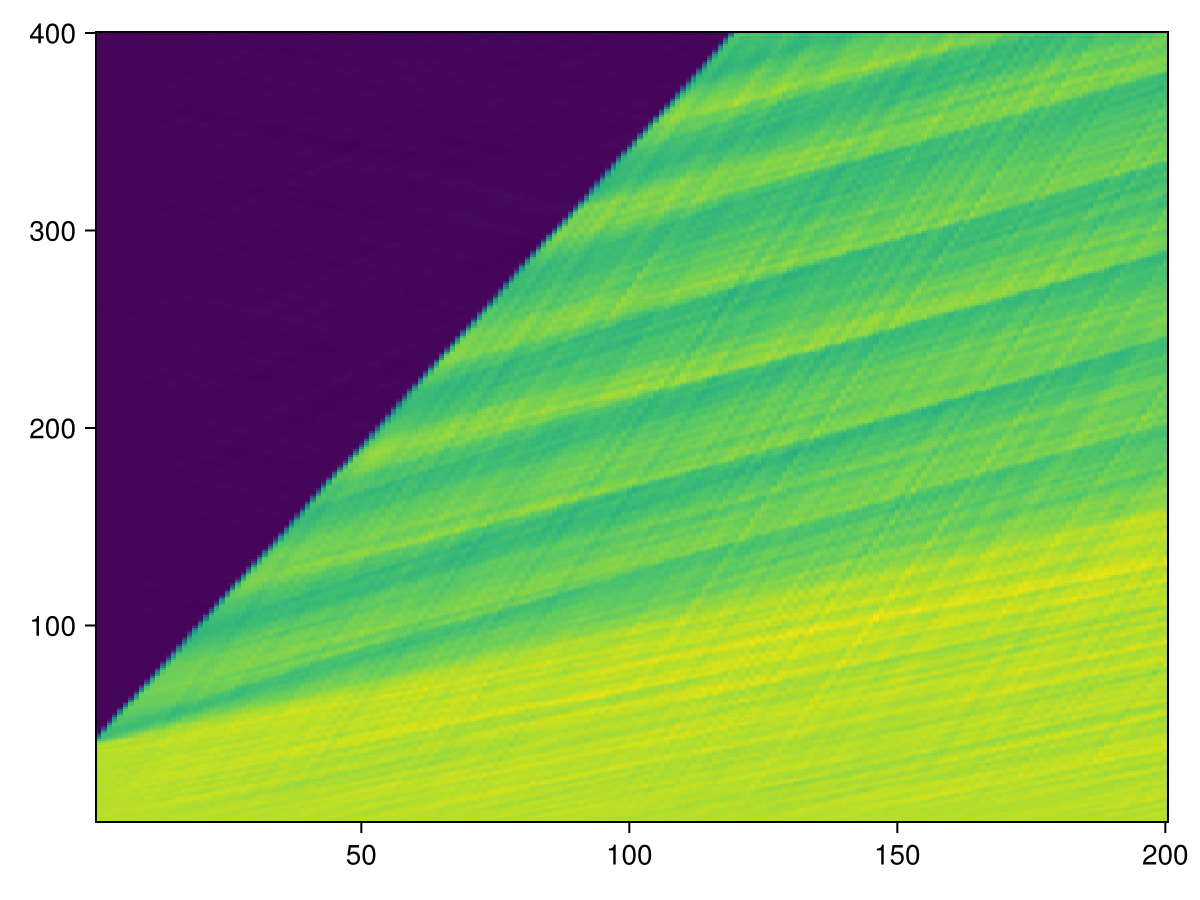

In [299]:
heatmap(data.xt[idxp, 1:end]')

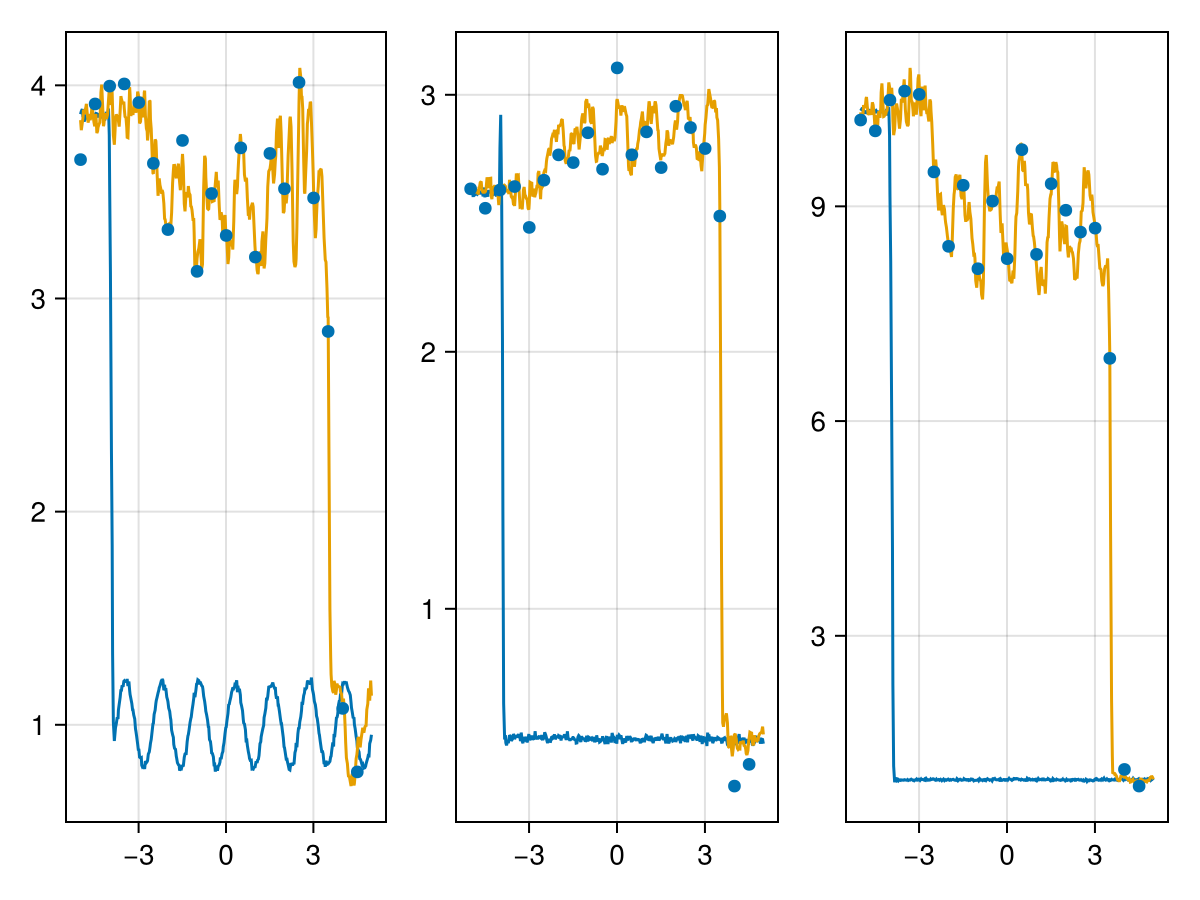

In [300]:
fig = Figure()


for (i, idx_i) in enumerate([(idxρ, idxρy), (idxv, idxvy), (idxp, idxpy)])
    idx_x, idx_y = idx_i
    axi = Axis(fig[1,i])
    lines!(axi, xgrid, data.xt[idx_x,1])
    lines!(axi, xgrid, data.xt[idx_x,100])
    scatter!(axi, xgrid[1:Δ:end], data.yt[idx_y,100])
end

fig

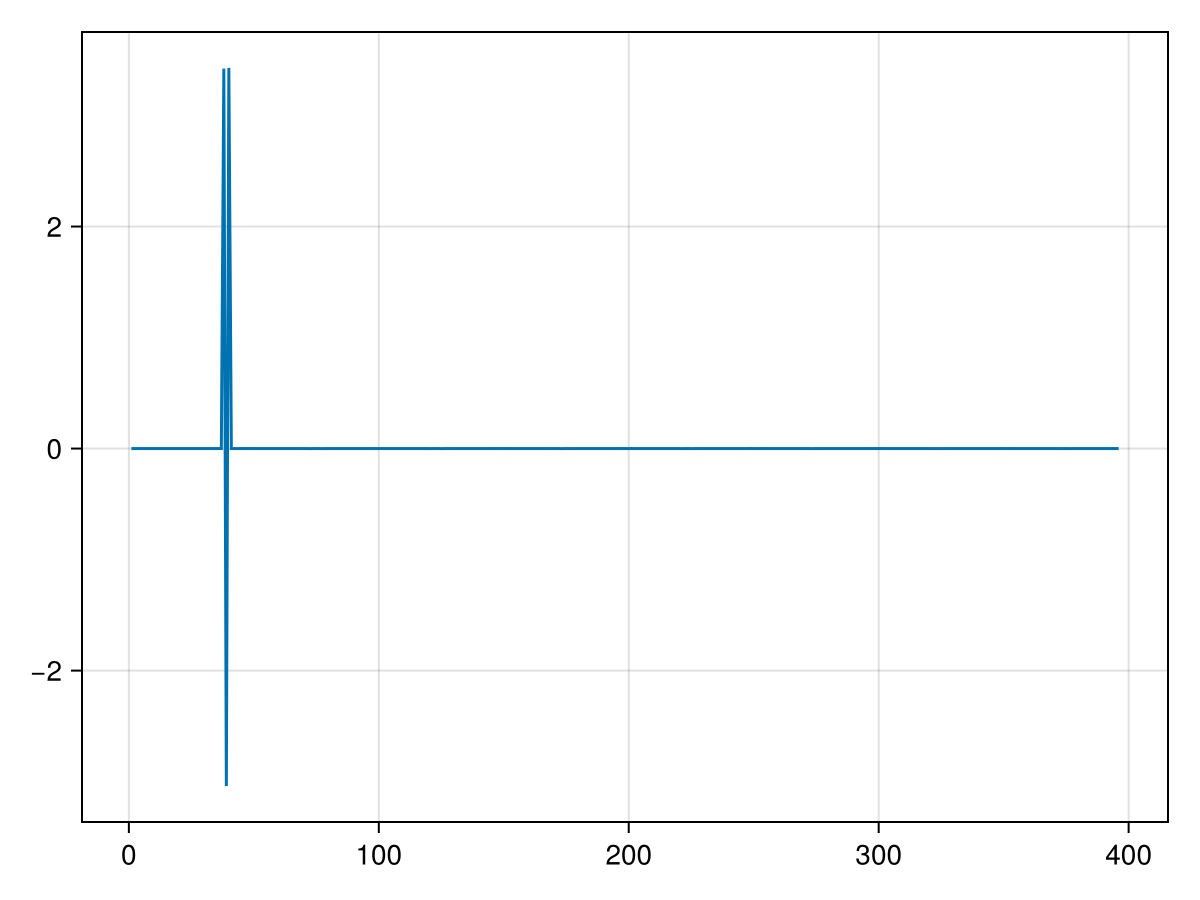

In [301]:
fig = Figure()
ax = Axis(fig[1,1])

# lines!(ax, xgrid, data.xt[:,1])
lines!(ax, (PA.P[:,idxρ]*data.x0[idxρ])[1:Nsvar])

fig

Define ObsConstraintSystem

In [302]:
idx = 3

## Selecion of hyper-prior parameters
# power parameter
r_range = [ 1.0, .5, -.5, -1.0 ]; 
r = r_range[idx] # select parameter 
# shape parameter
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
β = β_range[idx] # shape parameter
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 
ϑ = ϑ_range[idx]

# r = -0.5
# β = 0.5
# ϑ = 0.01
dist = GeneralizedGamma(r, β, ϑ);

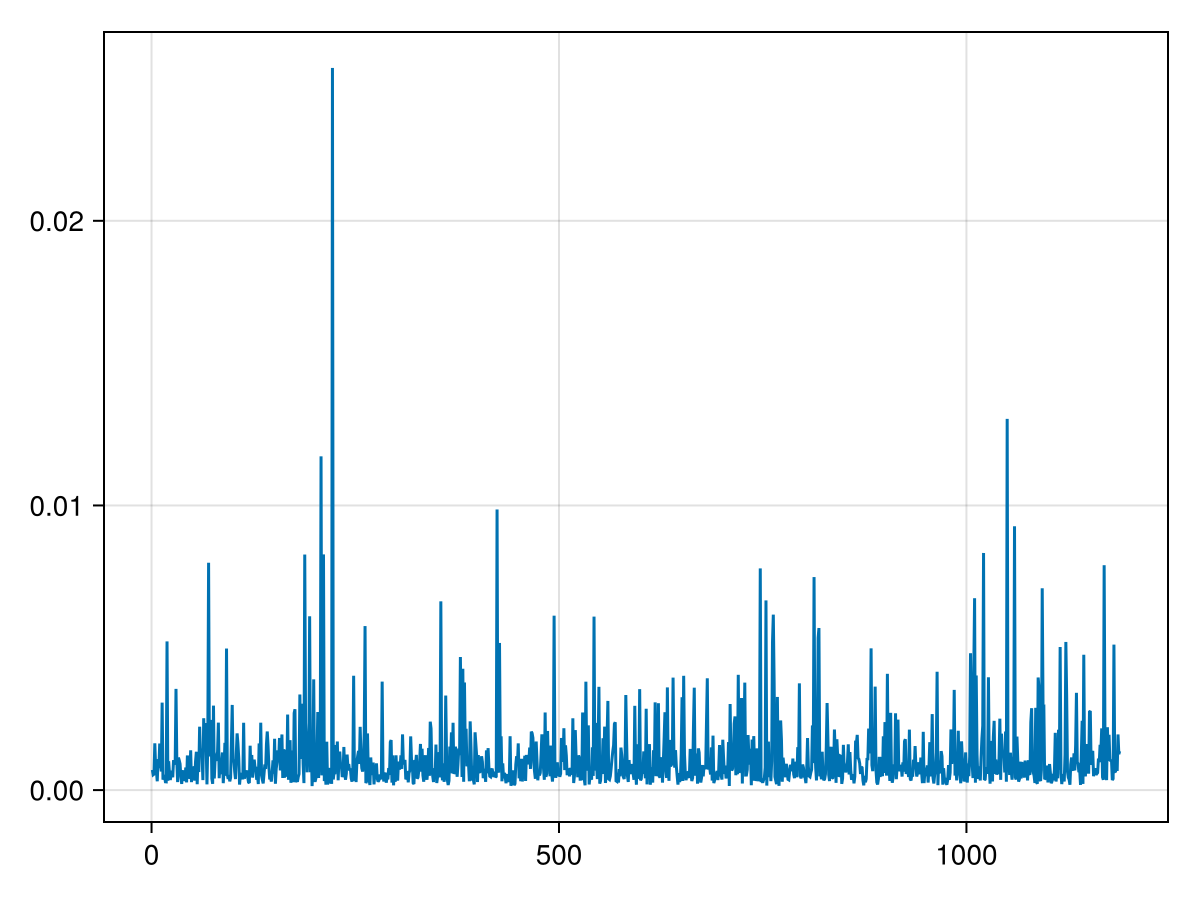

In [303]:
fig = Figure()

lines(rand(dist, Ns))

Create initial ensemble

In [304]:
xshuosher + 0.01*f0(xgrid)

1200-element Vector{Float64}:
 3.8555291963478036
 3.8555212631676667
 3.8555292251400313
 3.8555499596547027
 3.855566363768438
 3.8556074436323873
 3.855681700410474
 3.8557547644654884
 3.855799489935995
 3.855894332048794
 3.856039465746306
 3.856166957117195
 3.8562405775946904
 ⋮
 0.991239464712164
 0.9910880743326461
 0.9908820234698646
 0.9907181588061345
 0.9906289371873788
 0.9904583423954303
 0.9902304874444268
 0.9900527198407747
 0.9899571766668163
 0.9897769039133979
 0.9895409960392989
 0.9893607924003757

In [305]:
f0(xgrid)

1200-element Vector{Float64}:
 -0.16136607950537568
 -0.1621593975190373
 -0.16136320028261153
 -0.15928974881542926
 -0.15764933744191847
 -0.15354135104700067
 -0.1461156732382822
 -0.13880926773687646
 -0.13433672068620472
 -0.12485250940632726
 -0.11033913965513197
 -0.09759000256624521
 -0.09022795481669918
  ⋮
 -0.876053528783602
 -0.8911925667353893
 -0.9117976530135308
 -0.9281841193865602
 -0.9371062812621255
 -0.9541657604569733
 -0.9769512555573211
 -0.9947280159225299
 -1.0042823333183775
 -1.0223096086602137
 -1.0459003960701063
 -1.063920759962438

In [320]:
Ne = 40
X = zeros(model.Ny + model.Nx, Ne)

for i=1:Ne
    regenerate!(f0)
    X[Ny+1:Ny+Nx,i] = xshuosher + 0.02*f0(xgrid)#initial_condition(αk, Δx, Nx)
end

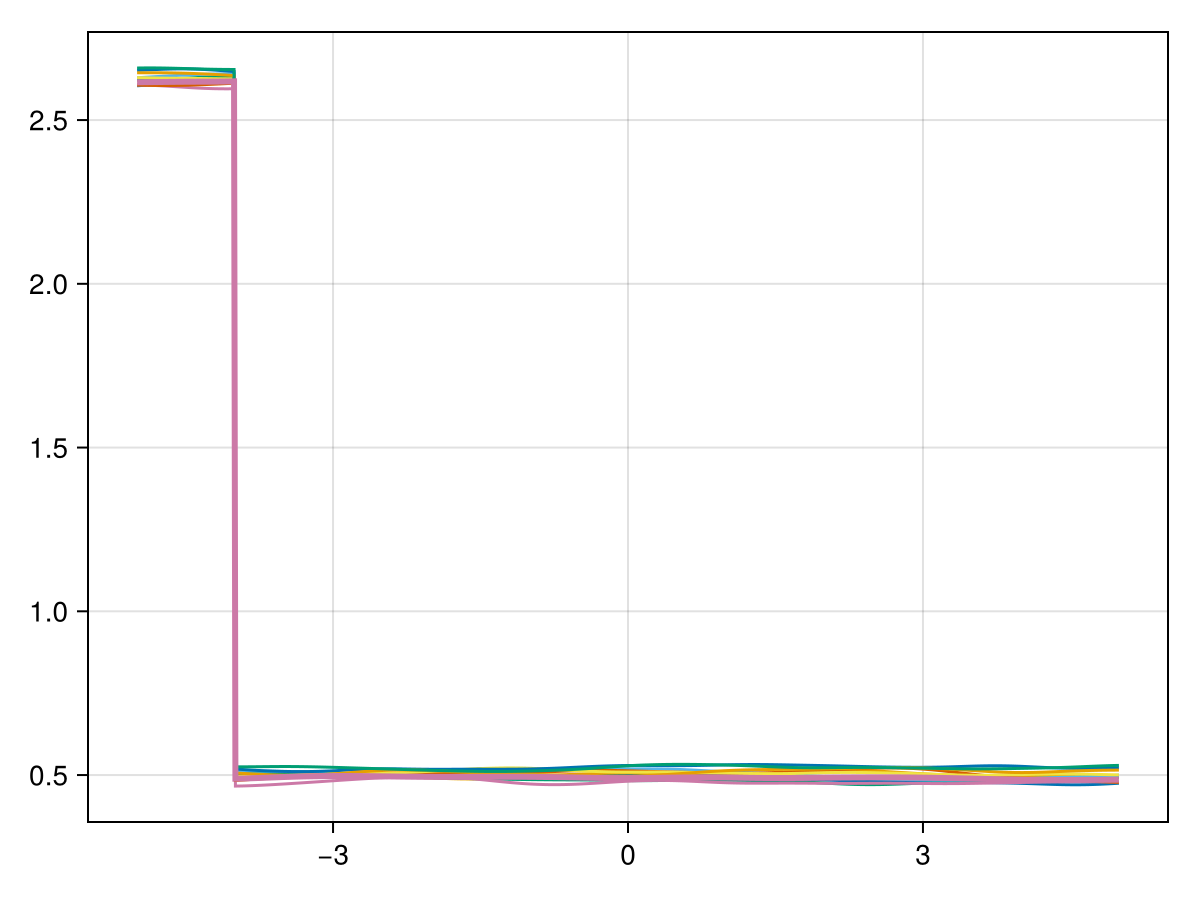

In [321]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, xgrid, X[Ny .+ idxv,i])
end
# lines!(xgrid, mean(X[Ny .+ idxρ,:]; dims = 2)[:,1], linewidth = 5, linestyle = :dash)

lines!(ax, xgrid, x0[idxv], linewidth = 3)

fig

Define initial guess

In [322]:
θinit = rand(dist, Ns);

Define linear maps and ObsConstraintSystem

In [323]:
Cθ = LinearMap(Diagonal(deepcopy(θinit)))
Cϵ = LinearMap(ϵy.Σ)
CX = LinearMap(Diagonal(1.0 .+ rand(Nx)))
sys_ys = ObsConstraintSystem(H, S, Cθ, Cϵ, CX)

ObsConstraintSystem(1200, 60, 1188, 60×1200 LinearMaps.WrappedMap{Float64} of
  60×1200 SparseMatrixCSC{Float64, Int64} with 60 stored entries, 1188×1200 LinearMaps.FunctionMap{Float64,true}(#31, #32; issymmetric=false, ishermitian=false, isposdef=false), 1188×1188 LinearMaps.WrappedMap{Float64} of
  1188×1188 Diagonal{Float64, Vector{Float64}}, 60×60 LinearMaps.WrappedMap{Float64} of
  60×60 Diagonal{Float64, Vector{Float64}}, LinearMap[1200×1200 LinearMaps.WrappedMap{Float64} of
  1200×1200 Diagonal{Float64, Vector{Float64}}])

In [324]:
sys_y = ObsSystem(H, Cϵ, CX)

ObsSystem(1200, 60, 60×1200 LinearMaps.WrappedMap{Float64} of
  60×1200 SparseMatrixCSC{Float64, Int64} with 60 stored entries, 60×60 LinearMaps.WrappedMap{Float64} of
  60×60 Diagonal{Float64, Vector{Float64}}, LinearMap[1200×1200 LinearMaps.WrappedMap{Float64} of
  1200×1200 Diagonal{Float64, Vector{Float64}}])

In [325]:
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# @assert length(yidx) == Ny

# # Create Localization structure
Gxx(i,j) = periodicmetric!(mod(i,Nxvar)-1,mod(j, Nxvar)-1, Nxvar)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nxvar)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nxvar)

Lrad = 10
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

Localization(10.0, Gxx, Gxy, Gxx)

In [326]:
β = 1.01
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(1200, 1.01, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

Define EnKF

In [327]:
enkf = EnKF(x-> abs.(x), Ne, ϵy, sys_y, Δtdyn, Δtobs)

Matrix-free implementation of the ensemble Kalman filter with filtered = false


Define localized EnKF

In [328]:
locenkf = LocEnKF(x-> abs.(x), Ne, ϵy, sys_y, Loc, Δtdyn, Δtobs)

Localized ensemble Kalman filter with filtered = false


Define hierarchical EnKF

In [329]:
henkf = HEnKF(x-> abs.(x), Ne, ϵy, sys_ys, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical ensemble Kalman filter with filtered = false


Define hierarchical and localized EnKF

In [330]:
hlocenkf = HLocEnKF(x-> abs.(x), Ne, ϵy, sys_ys, Loc, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical localized ensemble Kalman filter with filtered = false


In [331]:
X_enkf = seqassim_trixi(data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0, sys_euler);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


In [332]:
X_locenkf = seqassim_trixi(data, Tf, ϵxβ, locenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_euler);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


In [333]:
X_henkf, θ_henkf = seqassim_trixi(data, Tf, ϵxβ, henkf, deepcopy(X), model.Ny, model.Nx, t0, sys_euler);

Progress: 100%|█████████████████████████████████████████| Time: 0:27:18


In [334]:
X_hlocenkf, θ_hlocenkf = seqassim_trixi(data, Tf, ϵxβ, hlocenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_euler);

Progress: 100%|█████████████████████████████████████████| Time: 0:22:48


In [335]:
rmse_locenkf = mean(map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.07598631470335566

In [336]:
rmse_hlocenkf = mean(map(i->norm(data.xt[:,i]-mean(X_hlocenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.18417313420186332

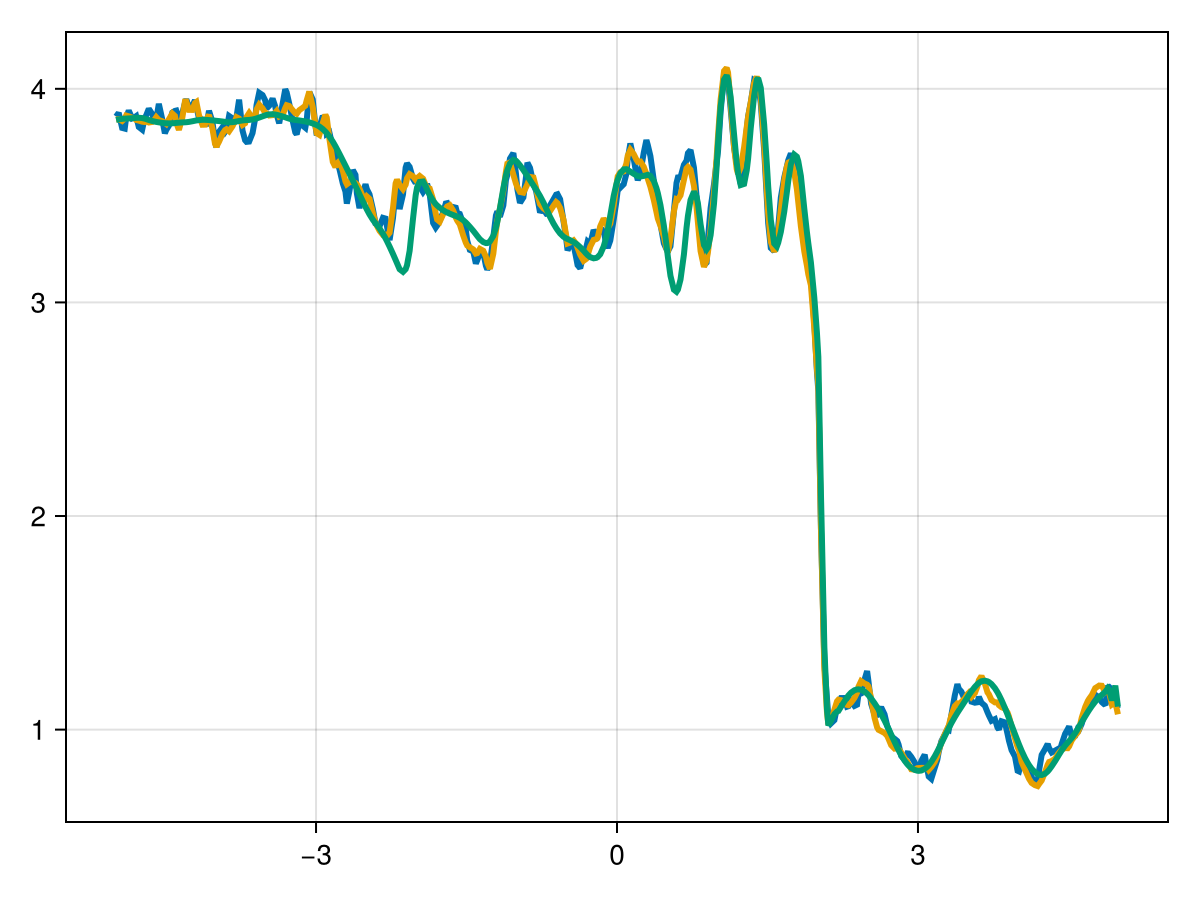

In [348]:
fig = Figure()


tsnap = 80
idx = 10



ax = Axis(fig[1,1])


lines!(ax, xgrid, data.xt[idxρ,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

# lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[idxρ,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

# lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[idxρ,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

# fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[idxpy,tsnap], linewidth = 3)


# scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

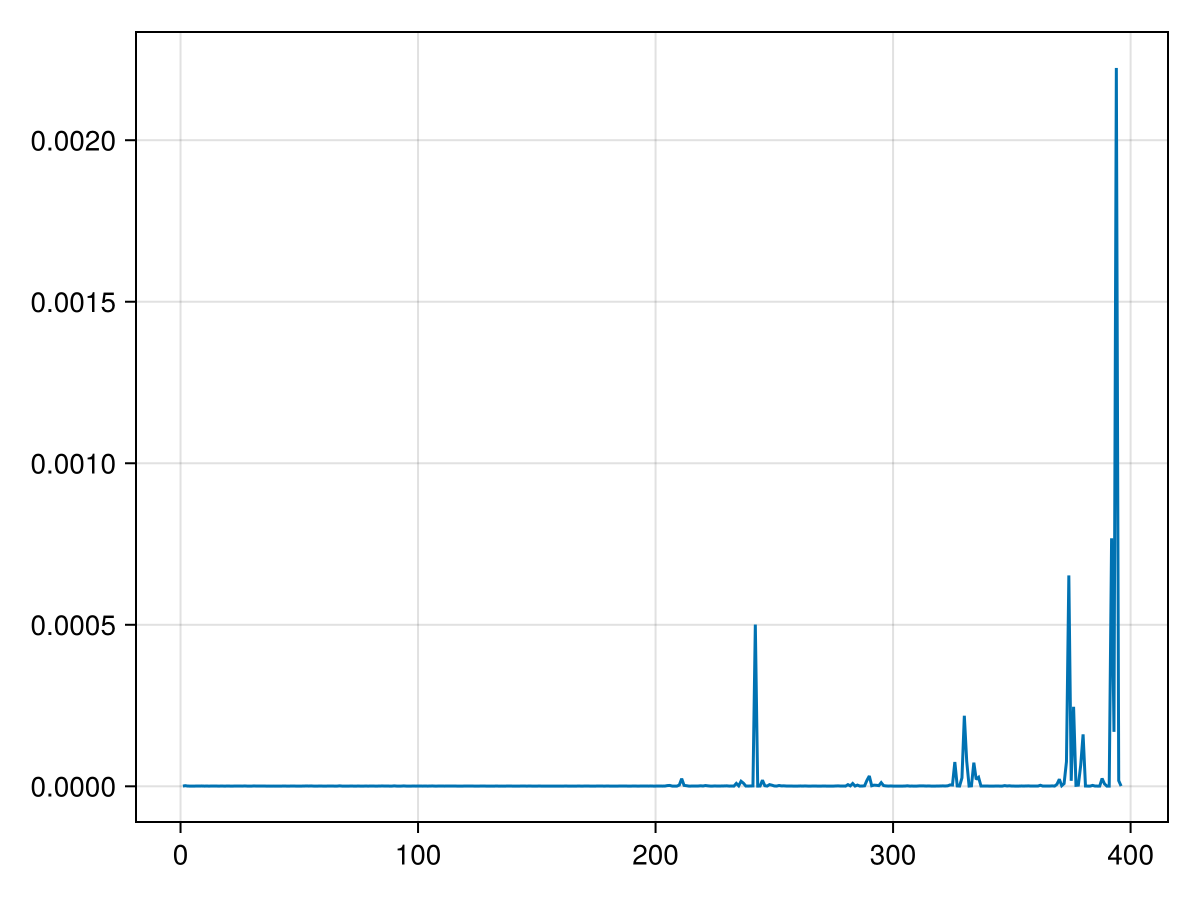

In [341]:
lines(θ_hlocenkf[end][idxρs])

In [342]:
tsnap = Observable(1)

x_tsnap = @lift(data.xt[idxρ,$tsnap])
y_tsnap = @lift(data.yt[idxρy,$tsnap])
X_locenkf_tsnap = @lift(mean(X_locenkf[$tsnap+1]; dims = 2)[idxρ,1])
X_hlocenkf_tsnap = @lift(mean(X_hlocenkf[$tsnap+1]; dims = 2)[idxρ,1])

scaled_θ_hlocenkf_tsnap = @lift(θ_hlocenkf[$tsnap+1][idxρs] / norm(θ_hlocenkf[$tsnap+1][idxρs]))


fig = Figure()


ax1 = Axis(fig[1,1])

lines!(ax1, xgrid, x_tsnap, linewidth = 3, label = "Truth")
lines!(ax1, xgrid, X_locenkf_tsnap, linewidth = 3, label = "LocEnKF")
lines!(ax1, xgrid, X_hlocenkf_tsnap, linewidth = 3, label = "HLocEnKF")
scatter!(ax1, xgrid[1:Δ:end], y_tsnap[idxρy])

axislegend(ax1)

ax2 = Axis(fig[1,2])

lines!(ax2, xs, scaled_θ_hlocenkf_tsnap, linewidth = 3, label = L"θ")
ylims!(ax2, 0.0, 0.6)

framerate = 10
timestamps = range(1, 100, step = 1)

record(fig, "shu_osher.mp4", timestamps; framerate = framerate) do t
    tsnap[] = t
end

LoadError: MethodError: no method matching getindex(::Observable{Vector{Float64}}, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  getindex(::Observable)
[0m[90m   @[39m [33mObservables[39m [90m~/.julia/packages/Observables/YdEbO/src/[39m[90m[4mObservables.jl:134[24m[39m
[0m  getindex(::Observables.AbstractObservable)
[0m[90m   @[39m [33mObservables[39m [90m~/.julia/packages/Observables/YdEbO/src/[39m[90m[4mObservables.jl:108[24m[39m


In [343]:
std(X_hlocenkf[end]; dims = 2)

1200×1 Matrix{Float64}:
 0.003283838039463976
 0.002161142254087395
 0.0022054178705407396
 0.002139623222561043
 0.0020357433068609655
 0.001908989845109988
 0.0018732818524155408
 0.0017744331498211695
 0.0017328346110449119
 0.001751365930582796
 0.0016344304190964382
 0.001341279732230249
 0.001195920072566114
 ⋮
 0.0028967772152474268
 0.0030830735852624028
 0.0035903496700311387
 0.0037894970397024472
 0.003952155902741236
 0.00417417471994378
 0.004148619237049782
 0.005388144571666883
 0.005494143178448867
 0.005974417356160694
 0.007587394475532868
 0.007320914895846006

In [344]:
std(X_locenkf[end]; dims = 2)

1200×1 Matrix{Float64}:
 0.010803197659680814
 0.01640426458054816
 0.026556832130374994
 0.03145333679890908
 0.029229655634365873
 0.03348554709716503
 0.028373208500996776
 0.035108145654246393
 0.03505783704492318
 0.03775204678900627
 0.036359071668104
 0.03892455691977148
 0.04187700594399044
 ⋮
 0.1284101458941983
 0.1460831258605491
 0.14530419653717472
 0.14077239274313566
 0.1269347525697246
 0.12222122844265186
 0.10893021436671785
 0.10171083393563328
 0.09363587114907186
 0.0765869262808985
 0.07489334202262705
 0.060575595810361024

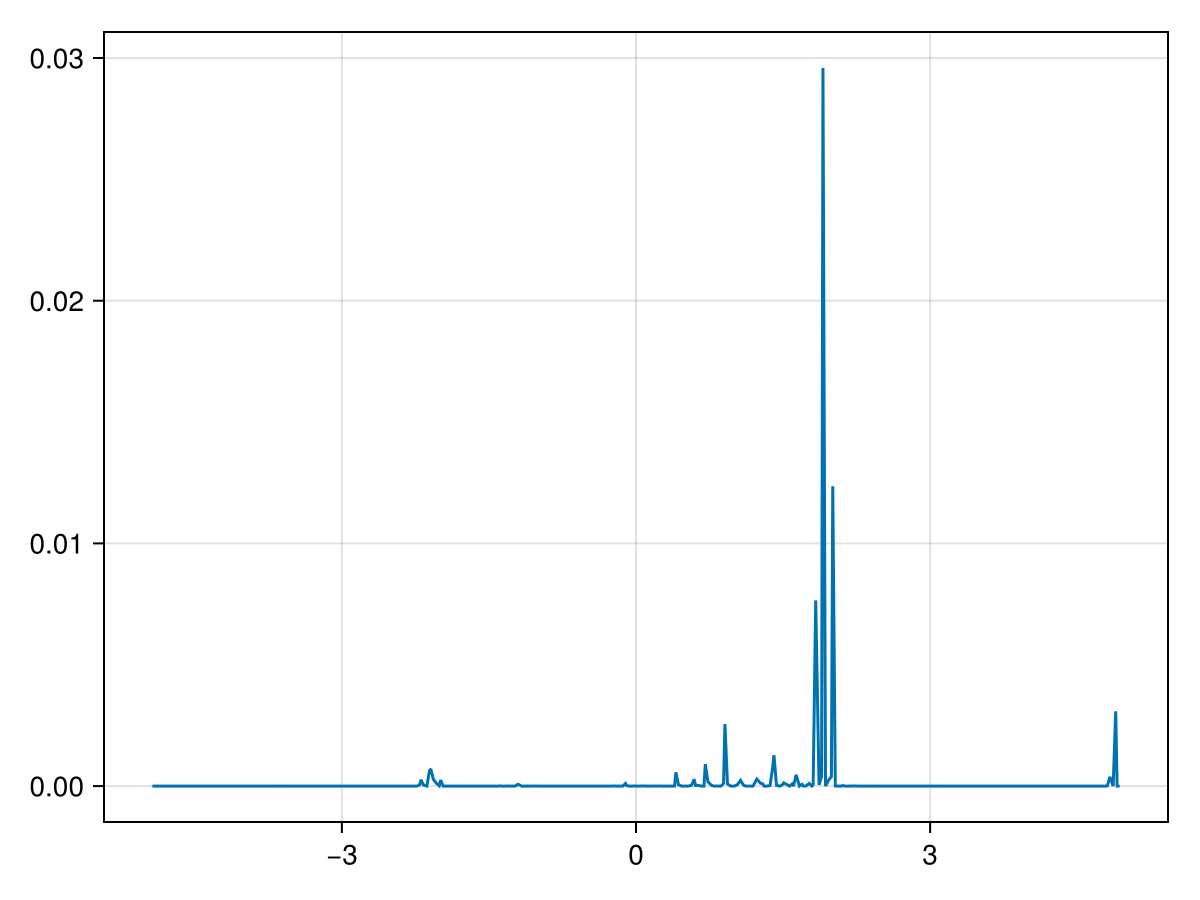

In [347]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 80

# lines!(ax, xs, θ_henkf[tsnap])
lines!(ax, xs, θ_hlocenkf[tsnap][idxρs])


fig